In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)

from libs.lib import *

d:\ads_test


In [2]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [3]:
exps_dir = "../../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [4]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone
# from mlxtend.classifier import StackingClassifier
from kerastuner.tuners import RandomSearch
from scipy.stats import uniform
import numpy as np

In [5]:
dict_data=[]
y_list = []
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels
for scaler in ['Standard_Label','MinMax_Label']:
    for type in ['basic','class_dict_weight','Oversampling','SMOTE','Undersampling']:
        x_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_train.xlsx')
        y_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_train.xlsx')
        x_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_test.xlsx')
        y_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_test.xlsx')
        y_list.append(y_test)
        y_train=oneHot(y_train)
        y_test=oneHot(y_test)
        print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
        dict_data.append((x_train,y_train,x_test,y_test))

class_weights_dict=dict(np.load(f'{exps_dir}/Standard_Label/class_dict_weight/feature/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict
print(len(dict_data))

(656, 42) (656, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(1001, 42) (1001, 2) (324, 42) (324, 2)
(1002, 42) (1002, 2) (324, 42) (324, 2)
(355, 42) (355, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(1001, 42) (1001, 2) (324, 42) (324, 2)
(1002, 42) (1002, 2) (324, 42) (324, 2)
(355, 42) (355, 2) (324, 42) (324, 2)
10


In [6]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

In [7]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)

In [8]:
x_test.shape

(324, 42)

In [9]:
x_train.shape

(656, 42)

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform

# Định nghĩa không gian siêu tham số
param_dist = {'C': uniform(0.1, 10),
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))}

# Khởi tạo mô hình SVM
svm_model = SVC()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, n_iter=5, scoring='accuracy', cv=5)
random_search.fit(x_train, y_train)

# In ra thông tin của mô hình SVM tốt nhất
print("Best SVM Hyperparameters:")
print(random_search.best_params_)
C=random_search.best_params_['C']
gamma=random_search.best_params_['gamma']
kernel=random_search.best_params_['kernel']

Best SVM Hyperparameters:
{'C': 3.52921084459783, 'gamma': 0.1, 'kernel': 'linear'}


In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Định nghĩa không gian siêu tham số
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20],
}

# Khởi tạo mô hình Random Forest
rf_model = RandomForestClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, scoring='accuracy', cv=5)
random_search_rf.fit(x_train, y_train)

# In ra thông tin của mô hình Random Forest tốt nhất
print("Best Random Forest Hyperparameters:")
print(random_search_rf.best_params_)
n_estimators=random_search_rf.best_params_['n_estimators']
max_depth=random_search_rf.best_params_['max_depth']


Best Random Forest Hyperparameters:
{'n_estimators': 100, 'max_depth': 15}


In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint

# Định nghĩa không gian siêu tham số cho Gradient Boosting
param_dist_gb = {'n_estimators': randint(50, 200),
                 'learning_rate': uniform(0.01, 0.1),
                 'max_depth': randint(3, 10),
                 'subsample': uniform(0.6, 0.4)}

# Khởi tạo mô hình Gradient Boosting
gb_model = GradientBoostingClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=5, scoring='accuracy', cv=5)
random_search_gb.fit(x_train, y_train)

# In ra thông tin của mô hình Gradient Boosting tốt nhất
print("Best Gradient Boosting Hyperparameters:")
print(random_search_gb.best_params_)
best_gb_model = random_search_gb.best_estimator_
max_depthgb=random_search_gb.best_params_['max_depth']
learning_rate=random_search_gb.best_params_['learning_rate']
n_estimatorsgb=random_search_gb.best_params_['n_estimators']
subsample=random_search_gb.best_params_['subsample']

Best Gradient Boosting Hyperparameters:
{'learning_rate': 0.08502128636780712, 'max_depth': 4, 'n_estimators': 95, 'subsample': 0.7930409903178746}


In [13]:
from sklearn.tree import DecisionTreeClassifier

# Định nghĩa không gian siêu tham số cho Decision Tree
param_dist_dt = {'criterion': ['gini', 'entropy'],
                 'splitter': ['best', 'random'],
                 'max_depth': randint(3, 10),
                 'min_samples_split': randint(2, 20),
                 'min_samples_leaf': randint(1, 20)}

# Khởi tạo mô hình Decision Tree
dt_model = DecisionTreeClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist_dt, n_iter=5, scoring='accuracy', cv=5)
random_search_dt.fit(x_train, y_train)

# In ra thông tin của mô hình Decision Tree tốt nhất
print("Best Decision Tree Hyperparameters:")
print(random_search_dt.best_params_)
best_dt_model = random_search_dt.best_estimator_
criterion=random_search_dt.best_params_['criterion']
max_depthdt=random_search_dt.best_params_['max_depth']
min_samples_leaf=random_search_dt.best_params_['min_samples_leaf']
splitter=random_search_dt.best_params_['splitter']
min_samples_split=random_search_dt.best_params_['min_samples_split']


Best Decision Tree Hyperparameters:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 12, 'splitter': 'best'}


#### * Xây dựng model:

In [14]:
#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=2)
#y_test = to_categorical(y_test, num_classes=2)
#y_train

In [15]:
import tensorflow as tf

def f1_loss(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32), axis=0)
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32), axis=0)
    actual_positives = tf.reduce_sum(tf.cast(y_true, tf.float32), axis=0)

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())

    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    macro_f1 = tf.reduce_mean(f1)
    
    return 1 - macro_f1


In [16]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [17]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=10e-06):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [19]:
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.models import Model
from keras.layers import Input
import tensorflow as tf
input_shape =(42,1)
x_input = Input(shape=input_shape)
dense_units = 1024
learning_rate = 0.001

# Block 1
x = Conv1D(352, 2, activation='relu', padding='same', name='block1_conv1')(x_input)
x = Conv1D(352, 2, activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block1_pool')(x)

# Block 2
x = Conv1D(192, 2, activation='relu', padding='same', name='block2_conv1')(x)
x = Conv1D(192, 2, activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block2_pool')(x)

# Block 3
x = Conv1D(128, 2, activation='relu', padding='same', name='block3_conv1')(x)
x = Conv1D(128, 2, activation='relu', padding='same', name='block3_conv2')(x)
x = Conv1D(128, 2, activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block3_pool')(x)

# Block 4
x = Conv1D(96, 2, activation='relu', padding='same', name='block4_conv1')(x)
x = Conv1D(96, 2, activation='relu', padding='same', name='block4_conv2')(x)
x = Conv1D(96, 2, activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block4_pool')(x)

# Block 5
x = Conv1D(96, 2, activation='relu', padding='same', name='block5_conv1')(x)
x = Conv1D(96, 2, activation='relu', padding='same', name='block5_conv2')(x)
x = Conv1D(96, 2, activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block5_pool')(x)

# x = Flatten(name='flatten')(x)
# x = Dense(dense_units, activation='relu', name='fc1')(x)
# x = Dense(dense_units, activation='relu', name='fc2')(x)
# x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

x = GlobalAveragePooling1D()(x)
#x = GlobalMaxPooling1D()(x)
x = Dense(2, activation='softmax', name='predictions')(x)  # Sigmoid for binary classification

# Create model.
model = Model(x_input, x, name='vgg16')
# model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy'])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy'])
model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=50,
    min_lr=0.000001,
    verbose=1,
)


In [20]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 42, 352)           1056      
                                                                 
 block1_conv2 (Conv1D)       (None, 42, 352)           248160    
                                                                 
 block1_pool (MaxPooling1D)  (None, 21, 352)           0         
                                                                 
 block2_conv1 (Conv1D)       (None, 21, 192)           135360    
                                                                 
 block2_conv2 (Conv1D)       (None, 21, 192)           73920     
                                                                 
 block2_pool (MaxPooling1D)  (None, 10, 192)           0     

In [21]:
#Set data order
data_order = 1

In [22]:
model.fit(x=dict_data[data_order][0],y=dict_data[data_order][1],
          validation_data=(dict_data[data_order][2],dict_data[data_order][3]),class_weight = class_weights_dict,
          batch_size=64,epochs= 1200, callbacks=[early_stopping,lr_scheduler])

Epoch 1/1200


11/11 [==============================] - 2s 71ms/step - loss: 0.3366 - accuracy: 0.7332 - val_loss: 0.2623 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 2/1200
11/11 [==============================] - 0s 31ms/step - loss: 0.2363 - accuracy: 0.7637 - val_loss: 0.2623 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 3/1200
11/11 [==============================] - 0s 31ms/step - loss: 0.2363 - accuracy: 0.7637 - val_loss: 0.2623 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 4/1200
11/11 [==============================] - 0s 29ms/step - loss: 0.2363 - accuracy: 0.7637 - val_loss: 0.2623 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 5/1200
11/11 [==============================] - 0s 30ms/step - loss: 0.2363 - accuracy: 0.7637 - val_loss: 0.2623 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 6/1200
11/11 [==============================] - 0s 30ms/step - loss: 0.2363 - accuracy: 0.7637 - val_loss: 0.2623 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 7/1200
11/11 [==============================] - 0s 30ms/step - loss: 0.

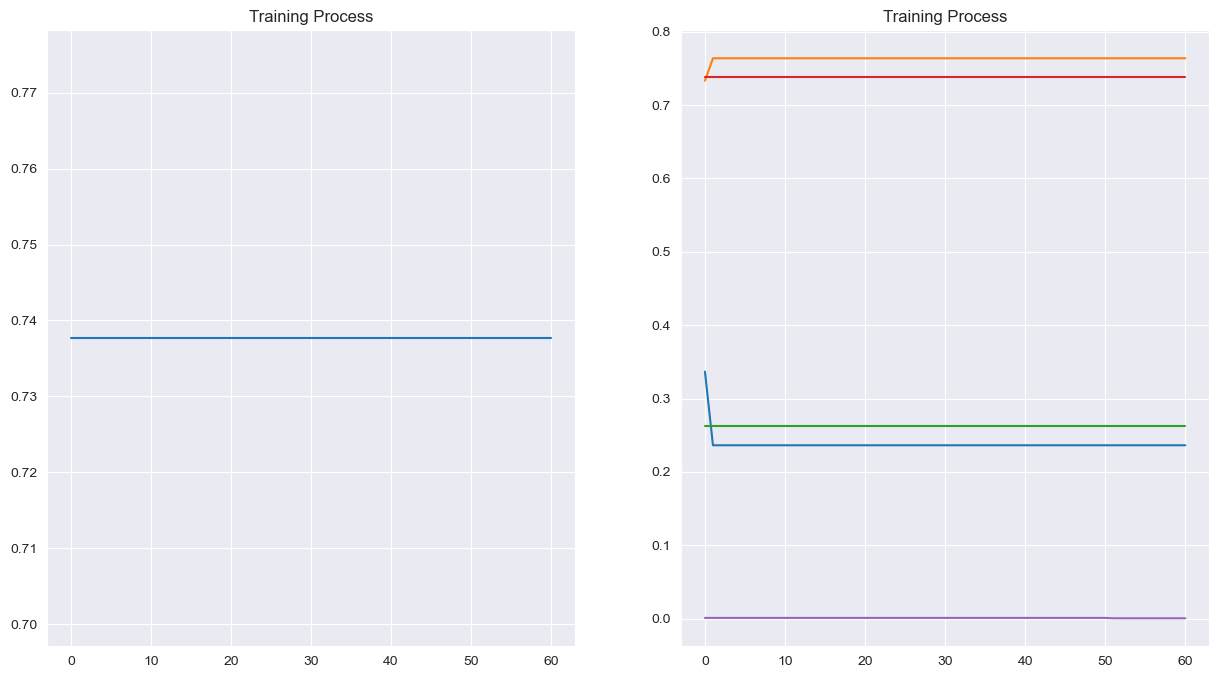

<Figure size 640x480 with 0 Axes>

In [23]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')
axes[1].plot(pd.DataFrame(history))
axes[1].set_title('Training Process')
plt.show()
plt.savefig('train.png')

In [24]:
predictions = model.predict(dict_data[data_order][2])
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_list[data_order], predictions)
accuracy

11/11 [==============================] - 0s 5ms/step


0.7376543209876543

In [25]:
x_test =dict_data[data_order][2]
y_test=y_list[data_order]

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.7376543209876543
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        85
           0       0.74      1.00      0.85       239

    accuracy                           0.74       324
   macro avg       0.37      0.50      0.42       324
weighted avg       0.54      0.74      0.63       324



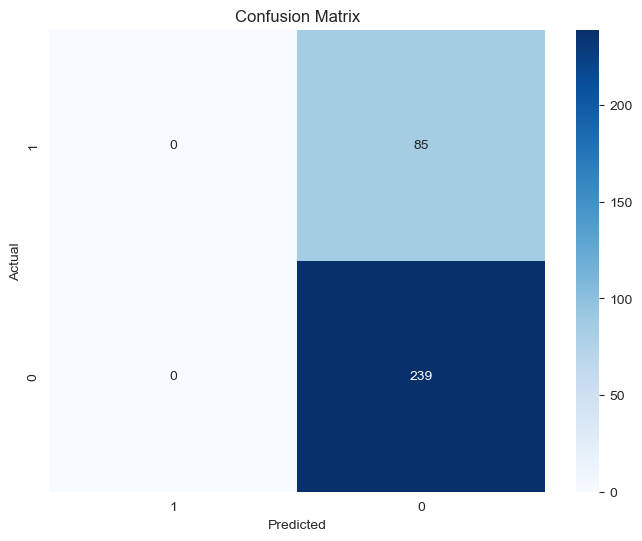

In [27]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

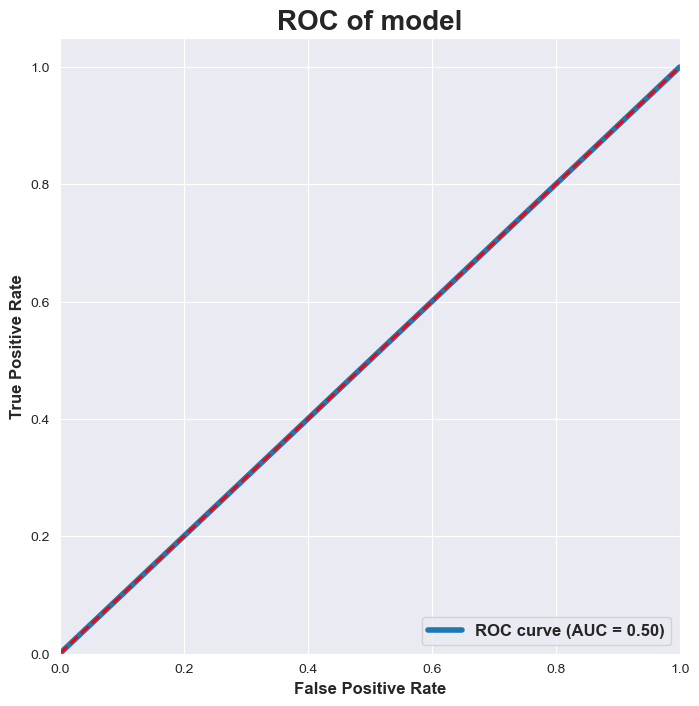

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

In [29]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [30]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------


In [31]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 239 chiếm khoảng 73.76543209876543% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 0 chiếm khoảng 0.0% so với thực tế
